In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report

In [31]:
models = ['InceptionV3', 'ResNet50', 'DenseNet121', 'InceptionResNetV2']
weights = ['radimagenet', 'imagenet']

In [32]:
preds_dict = {}
for model in models:
    for weight in weights:
        try:
            preds_dict['{}_{}'.format(model, weight)] = pd.read_csv('../preds/preds_{}_{}.csv'.format(model, weight))
        except:
            pass

In [33]:
tpr_dict = {}
fpr_dict = {}
auroc_dict = {}
for model in models:
    for weight in weights:
        try:
            fpr, tpr, _ = roc_curve(preds_dict['{}_{}'.format(model, weight)]['y_true'], preds_dict['{}_{}'.format(model, weight)]['y_pred'])
            tpr_dict['{}_{}'.format(model, weight)] = tpr
            fpr_dict['{}_{}'.format(model, weight)] = fpr
            auroc_dict['{}_{}'.format(model, weight)] = auc(fpr, tpr)
        except:
            pass

In [34]:
label_dict = {}
for model in models:
    for weight in weights:
        try:
            label_dict['{}_{}'.format(model, weight)] = '{} {} AUROC: '.format(model, weight) + str(round(auroc_dict['{}_{}'.format(model, weight)], 3))
        except:
            pass

In [35]:
prec_dict = {}
rec_dict = {}
auprc_dict = {}
for model in models:
    for weight in weights:
        try:
            prec, rec, _ = precision_recall_curve(preds_dict['{}_{}'.format(model, weight)]['y_true'], preds_dict['{}_{}'.format(model, weight)]['y_pred'])
            prec_dict['{}_{}'.format(model, weight)] = prec
            rec_dict['{}_{}'.format(model, weight)] = rec
            auprc_dict['{}_{}'.format(model, weight)] = auc(rec, prec)
        except:
            pass

In [36]:
prc_label_dict = {}
for model in models:
    for weight in weights:
        try:
            prc_label_dict['{}_{}'.format(model, weight)] = '{} {} AUPRC: '.format(model, weight) + str(round(auprc_dict['{}_{}'.format(model, weight)], 3))
        except:
            pass

In [37]:
blue_cmap = sns.color_palette("Blues_d", n_colors=4)
blue_cmap.reverse()
red_cmap = sns.color_palette("Reds_d", n_colors=4)
red_cmap.reverse()

In [38]:
#for each model with radimagenet weights, get a color from the blue_cmap corresponding to the AUROC
auroc_df = pd.DataFrame.from_dict(auroc_dict, orient='index').reset_index()
auroc_df.columns = ['model', 'auroc']
#for each auroc, get a rank 1-4 (1 is best, 4 is worst)
rad_df = auroc_df[auroc_df['model'].str.contains('radimagenet')]
in_df = auroc_df[~auroc_df['model'].str.contains('radimagenet')]
rad_df.sort_values('auroc', ascending=False, inplace=True)
in_df.sort_values('auroc', ascending=False, inplace=True)
rad_df['rank'] = rad_df['auroc'].rank(method='first', ascending=False).astype(int) - 1
in_df['rank'] = in_df['auroc'].rank(method='first', ascending=False).astype(int) - 1
print(len(rad_df), len(in_df))
rad_df.head()

4 4


/home/kchen/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_54740/1751246092.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad_df['rank'] = rad_df['auroc'].rank(method='first', ascending=False).astype(int) - 1
/tmp/ipykernel_54740/1751246092.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,model,auroc,rank
0,InceptionV3_radimagenet,0.707215,0
6,InceptionResNetV2_radimagenet,0.660405,1
4,DenseNet121_radimagenet,0.653548,2
2,ResNet50_radimagenet,0.643411,3


In [39]:
#for each model with radimagenet weights, get a color from the blue_cmap corresponding to the rank of the AUROC
blue_cmap_dict = {}
for model in models:    
    blue_cmap_dict['{}_{}'.format(model, 'radimagenet')] = blue_cmap[rad_df[rad_df['model'] == '{}_{}'.format(model, 'radimagenet')]['rank'].values[0]]
red_cmap_dict = {}
for model in models:
    try:
        red_cmap_dict['{}_{}'.format(model, 'imagenet')] = red_cmap[in_df[in_df['model'] == '{}_{}'.format(model, 'imagenet')]['rank'].values[0]]
    except:
        pass

<Figure size 864x864 with 0 Axes>

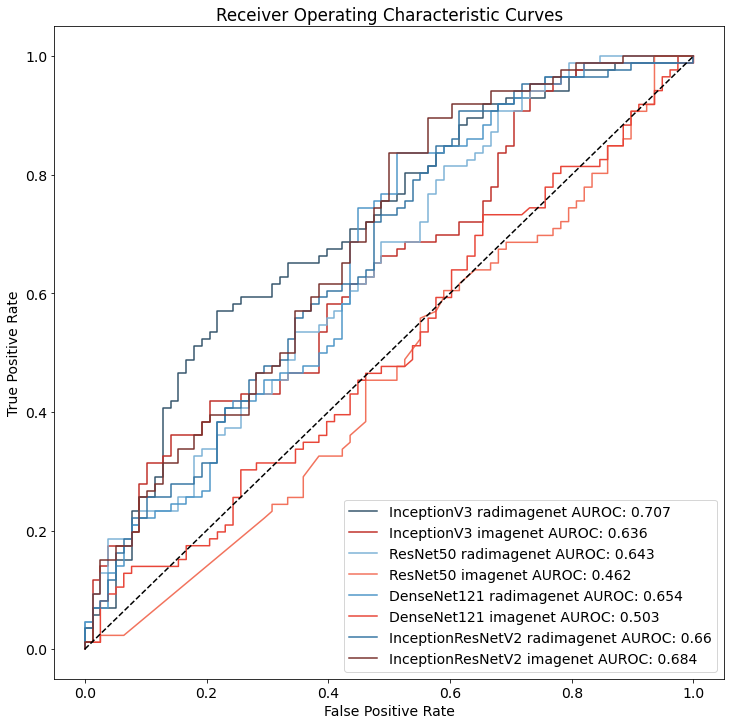

In [40]:
#plot the ROC curves, with radimagenet weights in blue and imagenet weights in red
plt.figure(figsize = (12, 12))
plt.figure(figsize = (12, 12))
for key, value in label_dict.items():
    if 'rad' in key:
        plt.plot(fpr_dict[key], tpr_dict[key], label = value, color = blue_cmap_dict[key])
    else:
        plt.plot(fpr_dict[key], tpr_dict[key], label = value, color = red_cmap_dict[key])
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc = 'lower right')
plt.rcParams.update({'font.size': 14})
# plt.show()
plt.savefig('../results/roc_rin_vs_in.png', dpi = 300, bbox_inches = 'tight')

In [41]:
#same process for AUPRC
auprc_df = pd.DataFrame.from_dict(auprc_dict, orient='index').reset_index()
auprc_df.columns = ['model', 'auprc']
rad_df = auprc_df[auprc_df['model'].str.contains('radimagenet')]
in_df = auprc_df[~auprc_df['model'].str.contains('radimagenet')]
rad_df.sort_values('auprc', ascending=False, inplace=True)
in_df.sort_values('auprc', ascending=False, inplace=True)
rad_df['rank'] = rad_df['auprc'].rank(method='first', ascending=False).astype(int) - 1
in_df['rank'] = in_df['auprc'].rank(method='first', ascending=False).astype(int) - 1
print(len(rad_df), len(in_df))

blue_cmap_dict_prc = {}
for model in models:
    blue_cmap_dict_prc['{}_{}'.format(model, 'radimagenet')] = blue_cmap[rad_df[rad_df['model'] == '{}_{}'.format(model, 'radimagenet')]['rank'].values[0]]
red_cmap_dict_prc = {}
for model in models:
    try:
        red_cmap_dict_prc['{}_{}'.format(model, 'imagenet')] = red_cmap[in_df[in_df['model'] == '{}_{}'.format(model, 'imagenet')]['rank'].values[0]]
    except:
        pass

4 4


/home/kchen/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_54740/1040663960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad_df['rank'] = rad_df['auprc'].rank(method='first', ascending=False).astype(int) - 1
/tmp/ipykernel_54740/1040663960.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [42]:
#make all the PRC curves start at 1, 0.53
for key, value in prec_dict.items():
    prec_dict[key] = np.insert(value, 0, 0.53)
    rec_dict[key] = np.insert(rec_dict[key], 0, 1)

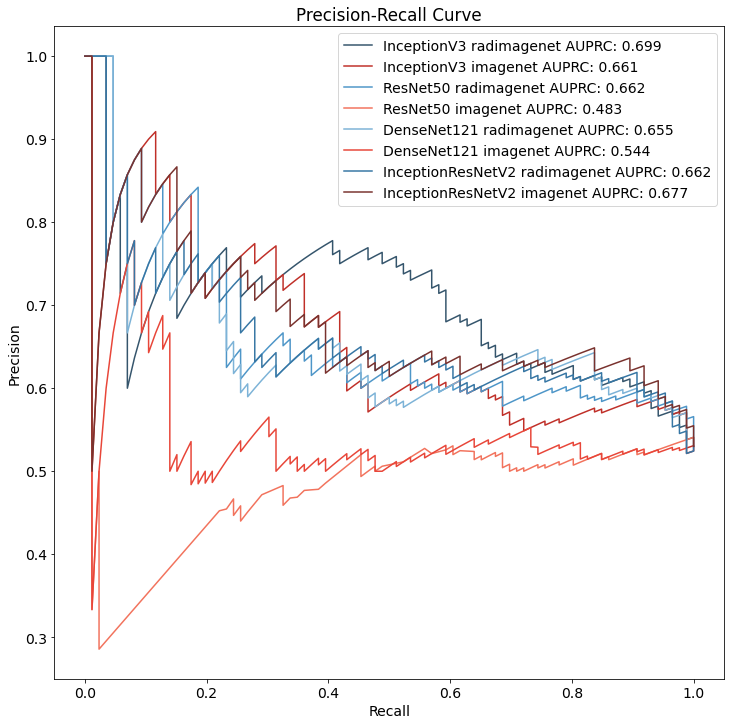

In [43]:
plt.figure(figsize = (12, 12))
for key, value in prc_label_dict.items():
    if 'rad' in key:
        plt.plot(rec_dict[key], prec_dict[key], label = value, color = blue_cmap_dict_prc[key])
    else:
        plt.plot(rec_dict[key], prec_dict[key], label = value, color = red_cmap_dict_prc[key])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc = 'upper right')
plt.rcParams.update({'font.size': 14})
plt.savefig('../results/prc_rin_vs_in.png', dpi = 300, bbox_inches = 'tight')

In [25]:
#make a dataframe with columns model name + weight, auroc, sensitivity, specificity, positive predictive value, negative predictive value
res_df = pd.DataFrame(columns = ['Model', 'AUROC', 'AUPRC', 'Sensitivity', 'Specificity', 'PPV', 'NPV'])
for key, value in label_dict.items():
    tn, fp, fn, tp = confusion_matrix(preds_dict[key]['y_true'], (preds_dict[key]['y_pred'] > 0.5)).ravel()
    res_df = res_df.append({'Model': key, 'AUROC': auroc_dict[key], 'AUPRC': auprc_dict[key], 'Sensitivity': tp/(tp + fn), 'Specificity': tn/(tn + fp), 'PPV': tp/(tp + fp), 'NPV': tn/(tn + fn)}, ignore_index = True)
res_df


/tmp/ipykernel_11089/4120599859.py:5: RuntimeWarning: invalid value encountered in long_scalars
  res_df = res_df.append({'Model': key, 'AUROC': auroc_dict[key], 'AUPRC': auprc_dict[key], 'Sensitivity': tp/(tp + fn), 'Specificity': tn/(tn + fp), 'PPV': tp/(tp + fp), 'NPV': tn/(tn + fn)}, ignore_index = True)
/tmp/ipykernel_11089/4120599859.py:5: RuntimeWarning: invalid value encountered in long_scalars
  res_df = res_df.append({'Model': key, 'AUROC': auroc_dict[key], 'AUPRC': auprc_dict[key], 'Sensitivity': tp/(tp + fn), 'Specificity': tn/(tn + fp), 'PPV': tp/(tp + fp), 'NPV': tn/(tn + fn)}, ignore_index = True)


,Model,AUROC,AUPRC,Sensitivity,Specificity,PPV,NPV
0,InceptionV3_radimagenet,0.707215,0.699197,0.837209,0.423077,0.615385,0.702128
1,InceptionV3_imagenet,0.635510,0.660857,0.802326,0.320513,0.565574,0.595238
2,ResNet50_radimagenet,0.643411,0.662113,0.825581,0.358974,0.586777,0.651163
3,ResNet50_imagenet,0.461837,0.482514,1.000000,0.000000,0.524390,NaN
4,DenseNet121_radimagenet,0.653548,0.654765,0.848837,0.384615,0.603306,0.697674
5,DenseNet121_imagenet,0.503131,0.543987,1.000000,0.000000,0.524390,NaN
6,InceptionResNetV2_radimagenet,0.660405,0.662203,0.883721,0.384615,0.612903,0.750000
7,InceptionResNetV2_imagenet,0.683661,0.676876,0.918605,0.371795,0.617188,0.805556


In [26]:
res_df.to_csv('../results/results_rin_vs_in.csv', index = False)